# 实验参数设置

In [4]:
from FederatedLearning.learner import CNNModel

clients_num = 10 # 客户端总数
rotation_cycle = 5 # 角色轮换间隔轮数
max_round = 20 # 联邦学习轮数
learning_rate = 0.01
model_class = CNNModel # 选用CNN模型

## 数据切分

In [5]:
import data_split
# 使用data_split模块中的函数获取PyTorch数据集
train_dataset = data_split.get_mnist_pytorch_dataset(train=True)
test_dataset = data_split.get_mnist_pytorch_dataset(train=False)
# test
# 使用正确的数据集对象创建数据加载器
client_dataloaders = data_split.create_client_dataloaders(train_dataset, clients_num // 2, 64, num_workers=clients_num) * 2
client_test_loader = data_split.create_client_dataloaders(test_dataset, clients_num // 2, 64) * 2

2025-10-21 09:51:28,564 - DGS_BCFL - INFO - 
切分5份数据集...
2025-10-21 09:51:28,565 - DGS_BCFL - INFO -  1 数据准备完成，样本数: 12000
2025-10-21 09:51:28,567 - DGS_BCFL - INFO -  2 数据准备完成，样本数: 12000
2025-10-21 09:51:28,568 - DGS_BCFL - INFO -  3 数据准备完成，样本数: 12000
2025-10-21 09:51:28,569 - DGS_BCFL - INFO -  4 数据准备完成，样本数: 12000
2025-10-21 09:51:28,571 - DGS_BCFL - INFO -  5 数据准备完成，样本数: 12000
2025-10-21 09:51:28,575 - DGS_BCFL - INFO - 
切分5份数据集...
2025-10-21 09:51:28,576 - DGS_BCFL - INFO -  1 数据准备完成，样本数: 2000
2025-10-21 09:51:28,576 - DGS_BCFL - INFO -  2 数据准备完成，样本数: 2000
2025-10-21 09:51:28,577 - DGS_BCFL - INFO -  3 数据准备完成，样本数: 2000
2025-10-21 09:51:28,578 - DGS_BCFL - INFO -  4 数据准备完成，样本数: 2000
2025-10-21 09:51:28,578 - DGS_BCFL - INFO -  5 数据准备完成，样本数: 2000


## 开始训练

In [6]:
from owner import Owner
from client import Client

# 初始化管理者，并获得初始化字典
owner = Owner(rotation_cycle=1, model_class=model_class)
main_dict = owner.get_main_dict()

# 初始化客户端以及身份
clients = [owner]
for i in range(clients_num):
    client_name = f"client_{i + 1}"
    client = Client(epochs=2, client_name=client_name, data_loader=client_dataloaders[i],
                    test_loader=client_test_loader[i], ModelClass=model_class, main_dict=main_dict, learning_rate=learning_rate)
    owner.join(client_name)
    clients.append(client)

import threading

for _ in range(max_round):
    t = [threading.Thread(target=client.run) for client in clients]
    _ = [i.start() for i in t]
    _ = [i.join() for i in t]


# 保存实验过程和结果
import pickle
with open("main_dict.pkl", "wb") as f:
    pickle.dump(main_dict, f)

2025-10-21 09:51:31,463 - DGS_BCFL - INFO - Owner开始初始化 角色
2025-10-21 09:51:31,465 - DGS_BCFL - INFO - [client_1] 当前轮次角色: aggregator
2025-10-21 09:51:31,467 - DGS_BCFL - INFO - [client_2] 当前轮次角色: validator
2025-10-21 09:51:31,467 - DGS_BCFL - INFO - [client_3] 当前轮次角色: validator
2025-10-21 09:51:31,469 - DGS_BCFL - INFO - [client_4] 当前轮次角色: validator
2025-10-21 09:51:31,470 - DGS_BCFL - INFO - [client_5] 当前轮次角色: learner
2025-10-21 09:51:31,473 - DGS_BCFL - INFO - [client_6] 当前轮次角色: learner
2025-10-21 09:51:31,486 - DGS_BCFL - INFO - [client_7] 当前轮次角色: learner
2025-10-21 09:51:31,488 - DGS_BCFL - INFO - [client_8] 当前轮次角色: learner
2025-10-21 09:51:31,492 - DGS_BCFL - INFO - [client_9] 当前轮次角色: learner
2025-10-21 09:51:31,494 - DGS_BCFL - INFO - [client_10] 当前轮次角色: learner
2025-10-21 09:51:31,668 - DGS_BCFL - INFO - Aggregator使用设备: cuda
2025-10-21 09:51:31,673 - DGS_BCFL - INFO - [client_4] 验证者初始化...
2025-10-21 09:51:31,675 - DGS_BCFL - INFO - [client_2] 验证者初始化...
2025-10-21 09:51:31,683 - D

## 计算结果可视化

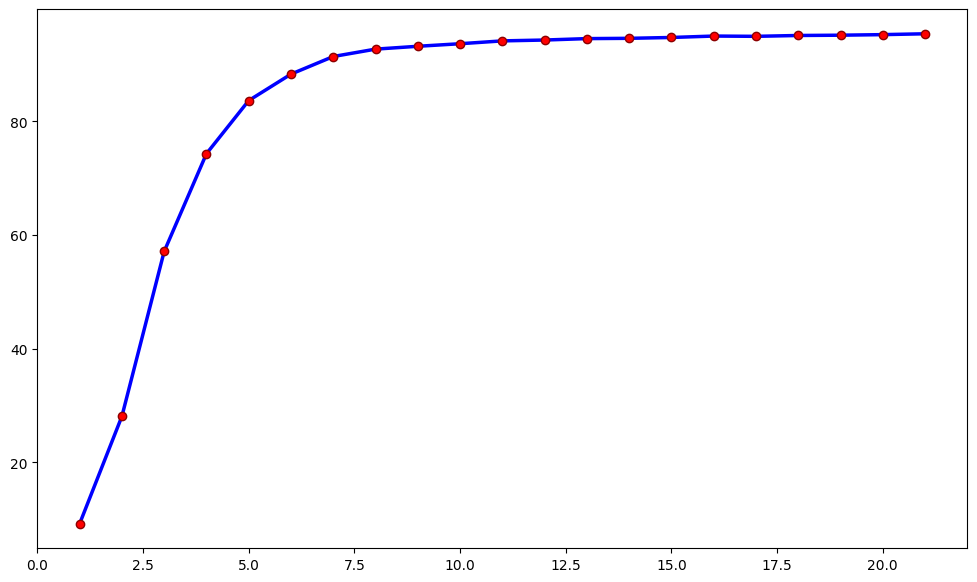

[[('client_10', 'client_2', True), ('client_10', 'client_3', True), ('client_10', 'client_4', True), ('client_6', 'client_2', True), ('client_6', 'client_3', True), ('client_6', 'client_4', True), ('client_8', 'client_4', True), ('client_8', 'client_2', True), ('client_8', 'client_3', True), ('client_5', 'client_4', True), ('client_5', 'client_2', True), ('client_5', 'client_3', True), ('client_9', 'client_4', True), ('client_9', 'client_3', True), ('client_9', 'client_2', True), ('client_7', 'client_3', True), ('client_7', 'client_4', True), ('client_7', 'client_2', True)], [('client_9', 'client_8', True), ('client_9', 'client_7', True), ('client_9', 'client_6', True), ('client_1', 'client_8', True), ('client_1', 'client_7', True), ('client_1', 'client_6', True), ('client_4', 'client_8', True), ('client_4', 'client_7', True), ('client_4', 'client_6', True), ('client_10', 'client_8', True), ('client_10', 'client_7', True), ('client_10', 'client_6', True), ('client_2', 'client_8', True)

In [12]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
# 读取实验结果
main_dict = pickle.load(open("main_dict.pkl", "rb"))

# 精确度变化可视化
global_accuracy_history = main_dict["global_accuracy_history"]
# 创建图形
plt.figure(figsize=(12, 7))

# 绘制主要曲线
epochs = list(range(1, len(global_accuracy_history) + 1))
plt.plot(epochs, global_accuracy_history, 'b-', linewidth=2.5, marker='o', markersize=6, 
         markerfacecolor='red', markeredgecolor='darkred', markeredgewidth=1, 
         label='模型准确度')
# 显示图表
plt.show()



print(main_dict["votes"])
print(main_dict["client_gradients"])

